## LGBM regression on complete multi-component data
### Using functional group features & cross validation 

**Created on 29th August, 2022; modified on 7th September; remodified on 10th February, 2024**

In [1]:
import warnings
warnings.filterwarnings('ignore')
#from sklearn.preprocessing import Imputer
# from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, \
    RidgeClassifier, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, \
RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc
import os, sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pickle
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
import pickle

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/ionic-conductivity_2.1/dataset_v2.0/common-log-output/lgbm_trials/random-split
total 51704
-rw-------@ 1 riteshk  staff  2653535 Feb 10 13:48 train_multi_comp_2d.csv
-rw-------@ 1 riteshk  staff   330545 Feb 10 13:48 val_multi_comp_2d.csv
-rw-------@ 1 riteshk  staff   333059 Feb 10 13:49 test_multi_comp_2d.csv
-rw-------@ 1 riteshk  staff  3208393 Feb 10 15:49 fgrp_2d_feat_all_multi_comp.csv
-rw-r--r--@ 1 riteshk  staff  2712384 Feb 10 19:29 train_qsar_rand_cond.csv
-rw-r--r--  1 riteshk  staff   337847 Feb 10 19:29 val_qsar_rand_cond.csv
-rw-r--r--  1 riteshk  staff   340423 Feb 10 19:29 test_qsar_rand_cond.csv
-rw-r--r--  1 riteshk  staff  3386654 Feb 10 19:30 all_qsar_cond.csv
-rw-r--r--  1 riteshk  staff      437 Feb 10 19:40 best-paramters_lgbr_random.txt
-rw-r--r--  1 riteshk  staff      869 Feb 10 19:40 best-paramters_lgbr_all.txt
-rw-r--r--  1 riteshk  staff   286566 Feb 10 21:15 l

In [3]:
df = pd.read_csv('all_qsar_cond.csv')
df

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,conductivity_log
0,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0,25.0,1.068186
1,O=C1OCCO1.CCCCOC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0,25.0,0.770852
2,O=C1OCCO1.CC(C)COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0,25.0,0.732394
3,O=C1OCCO1.CCC(C)OC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0,25.0,0.812913
4,CCOC(=O)OCC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,16,2,279.917842,1.0,10.0,0.322219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10191,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,0.1,30.0,0.672098
10192,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,0.5,30.0,1.139879
10193,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0,30.0,1.204120
10194,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.5,30.0,1.167317


Read the train, validation, and test sets

In [4]:
train_df = pd.read_csv('train_qsar_rand_cond.csv')
val_df = pd.read_csv('val_qsar_rand_cond.csv')
test_df = pd.read_csv('test_qsar_rand_cond.csv')
test_df

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,conductivity_log
0,CC1COC(=O)O1.O=C1OCCO1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,2.004762,60.00,0.896019
1,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0,0,0,0,0,0,0,0,...,0,0,0,0,14,0,186.969171,0.430000,59.00,0.870604
2,CC1COC(=O)O1.C1COC(=O)O1,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0,0,0,0,0,0,0,0,...,0,0,0,0,14,0,186.969171,0.480000,59.00,0.873721
3,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].[B-](F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,6,0,87.003467,2.000000,-30.00,-0.730378
4,O=C1OCCO1,[Li+].F[As-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,188.912016,1.000000,60.00,1.196453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,CC1CCCO1.O=C1OCCO1.CC1COC(=O)O1,[Li+].F[As-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,188.912016,1.000000,-30.00,0.550228
1016,C1COB(OCCOB2OCCCO2)OC1,[Li+].[O-]Cl(=O)(=O)=O,0,0,0,2,0,0,0,0,...,0,0,0,0,6,0,98.949060,1.000000,30.00,-3.790485
1017,CC1COC(=O)O1.CCOC(=O)OCC,CC[N+](CC)(CC)CC.F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,1,16,0,144.964181,1.160764,10.00,0.920819
1018,COCCOCCOCCOCCOC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,16,2,279.917842,2.347062,50.04,0.468790


In [5]:
## removing 'fr_func_grp_20_salt' columns from the dataframes since it contains only zero as entries, which makes it incompatible with Sobol analysis
df.drop(columns='fr_func_grp_20_salt', inplace=True)
train_df.drop(columns='fr_func_grp_20_salt', inplace=True)
val_df.drop(columns='fr_func_grp_20_salt', inplace=True)
test_df.drop(columns='fr_func_grp_20_salt', inplace=True)
train_df

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,conductivity_log
0,CCOCCOCCF.O=C1OCCO1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0000,15.0,0.819544
1,CC1COC(=O)O1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,0.4800,-0.2,0.468166
2,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,0.4800,-29.5,0.157312
3,COCCOC.COCCOCC(F)(F)C(F)F,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,16,2,279.917842,1.0000,40.0,0.806858
4,CC1COC(=O)O1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.7000,25.0,0.707570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8161,FC(F)C(F)(F)COC(F)(F)C(F)F.COC(=O)OCC(F)(F)F.O...,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.2000,25.0,0.477121
8162,CCCCCCCCCC1COC(=O)O1,[Li+].C(F)(F)(F)S(=O)(=O)[O-],0,0,0,0,0,0,0,0,...,0,0,0,0,9,0,148.952573,0.3000,25.0,-1.315155
8163,COCCOCCOCCOCCOC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,16,2,279.917842,1.2700,30.0,0.513458
8164,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,0.6524,59.0,1.092370


In [6]:
X_train = train_df.iloc[:,2:-1]
y_train = train_df.iloc[:,-1]
X_test = test_df.iloc[:,2:-1]
y_test = test_df.iloc[:,-1]
X_val = val_df.iloc[:,2:-1]
y_val = val_df.iloc[:,-1]
X_train

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,fr_func_grp_39_salt,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature
0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,8,0,144.964181,1.0000,15.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,144.964181,0.4800,-0.2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,144.964181,0.4800,-29.5
3,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,16,2,279.917842,1.0000,40.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,144.964181,1.7000,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8161,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,8,0,144.964181,1.2000,25.0
8162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,9,0,148.952573,0.3000,25.0
8163,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,16,2,279.917842,1.2700,30.0
8164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,144.964181,0.6524,59.0


#### Step 1: Bayesian hyperparameter optimization

In [7]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std  = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)
X_val_std  = std_scale.transform(X_val)
X_val_std = pd.DataFrame(X_val_std, columns=X_train.columns)

In [8]:
X_train_ = np.array(X_train_std)
X_val_ = np.array(X_val_std)
X_test_ = np.array(X_test_std)

In [9]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    param = {
        "objective": "regression",
        "metric": "root_mean_squared_error",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 100),
        "num_iterations": trial.suggest_int("num_iterations", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "max_bin": trial.suggest_int("max_bin", 2, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.9),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.1, 0.9)
    }

    gbm = LGBMRegressor(**param)
    cv = cross_val_score(gbm, X_train_, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    return -cv.mean()

In [10]:
fname = 'best-paramters_lgbr_random.txt'
f = open(fname, 'w')
f1 = open('best-paramters_lgbr_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

[I 2024-02-14 01:18:36,944] A new study created in memory with name: no-name-a381c684-16d9-4716-b26d-fe3de36396a0
[I 2024-02-14 01:18:38,465] Trial 0 finished with value: 0.34397368961971064 and parameters: {'lambda_l1': 1.181588349170113e-06, 'lambda_l2': 1.7558873986103173e-06, 'num_leaves': 16, 'num_iterations': 143, 'max_depth': 9, 'max_bin': 41, 'feature_fraction': 0.44035137092111004, 'bagging_fraction': 0.4796856425240132, 'bagging_freq': 7, 'min_data_in_leaf': 69, 'min_gain_to_split': 0.9136652485754788, 'learning_rate': 0.046065482541105915, 'min_sum_hessian_in_leaf': 0.4134981259408494}. Best is trial 0 with value: 0.34397368961971064.
[I 2024-02-14 01:18:39,610] Trial 1 finished with value: 0.3058139775116001 and parameters: {'lambda_l1': 0.3684946785742875, 'lambda_l2': 0.0008872514758149759, 'num_leaves': 19, 'num_iterations': 464, 'max_depth': 6, 'max_bin': 46, 'feature_fraction': 0.46520861212492154, 'bagging_fraction': 0.3147534465529014, 'bagging_freq': 10, 'min_data_i

Number of finished trials: 200
Best trial:
  Value: 0.21162123533078864
  Params: 
    lambda_l1: 1.6207176580357287e-08
    lambda_l2: 6.50531167525302e-08
    num_leaves: 14
    num_iterations: 432
    max_depth: 8
    max_bin: 50
    feature_fraction: 0.5490618064841022
    bagging_fraction: 0.5680137984610684
    bagging_freq: 1
    min_data_in_leaf: 9
    min_gain_to_split: 0.1000151242891819
    learning_rate: 0.44223032903676884
    min_sum_hessian_in_leaf: 0.562444561980657


In [11]:
def read_param():
    fname = 'best-paramters_lgbr_random.txt'
    f0 = open(fname,'r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = int(b[4][1])
    p5 = int(b[5][1]); p6 = int(b[6][1]); p7 = float(b[7][1]); p8 = float(b[8][1])
    p9 = int(b[9][1]); p10 = int(b[10][1]); p11 = float(b[11][1]); p12 = float(b[12][1])
    p13 = float(b[13][1])
    return p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13

In [12]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13 = read_param()
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}
print(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13)

1.6207176580357287e-08 6.50531167525302e-08 14 432 8 50 0.5490618064841022 0.5680137984610684 1 9 0.1000151242891819 0.44223032903676884 0.562444561980657


In [13]:
## optimize over random states of KFold
rmse_cv_array = []
for i in range(0,100):
    print(f"Step {i}")
    # Initialize KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=i)
    # stratify_labels = df_train['CE_binned']
    lgbm = LGBMRegressor(**params, verbose=-1)
    # plsr = PLSRegression(n_components=ncomp, scale=True) ## don't use scale=True

    fold = 1
    # Loop over each fold
    rmse_val = []; rmse_train = []
    for train_index, val_index in kf.split(X_train_):
        # print("Fold {}".format(fold))
        # Split the data
        X_train_fold, X_val_fold = X_train_[train_index], X_train_[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Fit the model on the training data
        lgbm.fit(X_train_fold, y_train_fold)

        y_pred_val_fold = lgbm.predict(X_val_fold)
        r2 = r2_score(y_val_fold, y_pred_val_fold); rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val_fold)); mae = mean_absolute_error(y_val_fold, y_pred_val_fold)
        # print(f"Train set CV, R2 score: {r2}, RMSE: {rmse}, MAE: {mae}")
        rmse_train.append(rmse)

        ## predict on validation test
        y_pred_val = lgbm.predict(X_val_)
        r2 = r2_score(y_val, y_pred_val); rmse = np.sqrt(mean_squared_error(y_val, y_pred_val)); mae = mean_absolute_error(y_val, y_pred_val)
        # print(f"Validation set, R2 score: {r2}, RMSE: {rmse}, MAE: {mae}")
        rmse_val.append(rmse)

        fold += 1
    # print(f"RMSE train: {np.mean(rmse_train)} & RMSE val: {np.mean(rmse_val)}")
    rmse_cv_array.append(np.mean(rmse_train))

ind = min(range(len(rmse_cv_array)), key=rmse_cv_array.__getitem__)
print(rmse_cv_array[ind])

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
0.20325083436565056


In [14]:
## use the best random state to train the model
kf = KFold(n_splits=5, shuffle=True, random_state=ind)
# stratify_labels = df_train['CE_binned']

lgbm = LGBMRegressor(**params, verbose=-1)

fold = 1
# Loop over each fold
pred_train_array = []; pred_val_array = []; pred_test_array = []
for train_index, val_index in kf.split(X_train_):
    X_train_fold, X_val_fold = X_train_[train_index], X_train_[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the model on the training data
    lgbm.fit(X_train_fold, y_train_fold)

    # Store the model
    # models.append(plsr)
    y_pred_val_fold = lgbm.predict(X_val_fold)
    r2 = r2_score(y_val_fold, y_pred_val_fold); rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val_fold)); mae = mean_absolute_error(y_val_fold, y_pred_val_fold)
    
    y_pred_train = lgbm.predict(X_train_)
    pred_train_array.append(y_pred_train)

    ## predict on validation test
    y_pred_val = lgbm.predict(X_val_)
    pred_val_array.append(y_pred_val)

    # ## predict on test set
    y_pred_test = lgbm.predict(X_test_)
    pred_test_array.append(y_pred_test)

    ## save plsr model to pickle
    filename = f'./lgbm_cond_rand_fold_{fold}.sav'
    pickle.dump(lgbm, open(filename, 'wb'))
    fold += 1

## calculate the average of the predictions on train, val and test
y_pred_train_avg = np.mean(pred_train_array, axis=0); y_pred_val_avg = np.mean(pred_val_array, axis=0); y_pred_test_avg = np.mean(pred_test_array, axis=0)
r2_train = r2_score(y_train, y_pred_train_avg); rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_avg)); mae_train = mean_absolute_error(y_train, y_pred_train_avg)
r2_val = r2_score(y_val, y_pred_val_avg); rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_avg)); mae_val = mean_absolute_error(y_val, y_pred_val_avg)
r2_test = r2_score(y_test, y_pred_test_avg); rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_avg)); mae_test = mean_absolute_error(y_test, y_pred_test_avg)
print(f"RMSE train: {rmse_train} & RMSE val: {rmse_val} & RMSE test: {rmse_test}")
print(f"R2 train: {r2_train} & R2 val: {r2_val} & R2 test: {r2_test}")
print(f"MAE train: {mae_train} & MAE val: {mae_val} & MAE test: {mae_test}")

RMSE train: 0.1475937803076399 & RMSE val: 0.20645969303358405 & RMSE test: 0.21689129179391617
R2 train: 0.9594441747104359 & R2 val: 0.9186173576295823 & R2 test: 0.917735412856671
MAE train: 0.08797339517263131 & MAE val: 0.1065844204125727 & MAE test: 0.11474767923560612


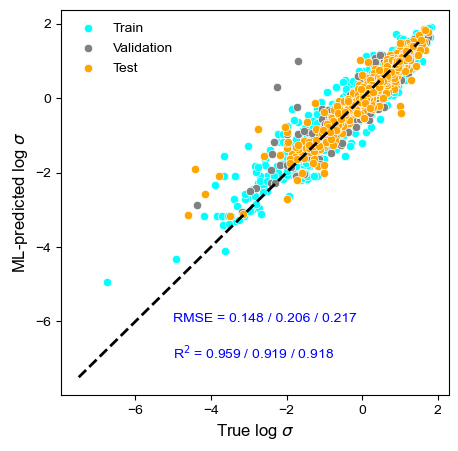

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
xl = np.arange(-7.5,2.5,1)
yl = np.arange(-7.5,2.5,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='black')  

# plt.tick_params(axis='both', direction='in')
plt.xlabel('True log $\sigma$',fontsize=12)
plt.ylabel('ML-predicted log $\sigma$',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
# plt.grid()
plt.text(-5, -6, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train, rmse_val, rmse_test), color='blue')
plt.text(-5, -7, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(r2_train, r2_val, r2_test), color='blue')
plt.legend(frameon=False)
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_cv_1.jpg'
# plt.savefig(filename, dpi=300)

**Predict on OOD**

In [17]:
df_ood = pd.read_csv('./ood_qsar_fgrp_cond.csv')
df_ood.drop(columns='fr_func_grp_20_salt', inplace=True)
X_ood = df_ood.iloc[:,2:-1]
y_ood = df_ood.iloc[:,-1]
X_ood_std = std_scale.transform(X_ood)
X_ood_std = pd.DataFrame(X_ood_std, columns=X_ood.columns)
X_ood_ = np.array(X_ood_std)
df_ood

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,conductivity_log
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,0,10,2,186.939685,1.0,80,0.333390
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,0,10,2,186.939685,1.0,70,0.297290
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,0,10,2,186.939685,1.0,60,0.254010
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,0,10,2,186.939685,1.0,50,0.202220
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,0,10,2,186.939685,1.0,40,0.137990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,0,10,2,186.939685,1.2,25,0.503791
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,0,10,2,186.939685,1.0,25,0.474216
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,0,10,2,186.939685,1.0,25,-0.585027
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0,0,0,0,0,0,0,0,...,0,0,0,0,10,2,186.939685,3.0,25,-0.356547


In [18]:
## predict on ood & check performance
pred_array = []
for i in range(1,6):
    print(i)
    filename = f'./lgbm_cond_rand_fold_{i}.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    y_pred_ood = loaded_model.predict(X_ood_)
    pred_array.append(y_pred_ood)

y_l = x_l = np.linspace(-6, -0.5, 100)
y_pred_ood_avg = np.mean(pred_array, axis=0)
y_pred_ood_avg = np.ravel(y_pred_ood_avg)
y_pred_ood_std = np.std(pred_array, axis=0)
y_pred_ood_std = np.ravel(y_pred_ood_std)
rmse_ood = np.sqrt(mean_squared_error(y_ood, y_pred_ood_avg)); mae_ood = mean_absolute_error(y_ood, y_pred_ood_avg)
# r2_ood = r2_score(y_ood, y_pred_ood_avg)
print(f"Avg RMSE ood: {rmse_ood}, Avg MAE ood: {mae_ood}")

1
2
3
4
5
Avg RMSE ood: 0.5211517972627171, Avg MAE ood: 0.4121988389380869
